## Spark Streaming 

- Separate library in Spark to process continuously flowing streaming data

- Provides a high-level abstraction called discretized stream or DStream APIwhich represents a continuous stream of data and is represented as a sequence of RDDs.
- DStreams provide us data divided in chunks as RDDs received from the source of Streaming to be processed and after processing sends it to the destination.

- Spark streaming works on micro batch.

- Stream pipeline is registered with some operations and the Spark polls the source after every batch duration (defined in the application)

- Each incoming record belongs to a batch of DStream.

- Each batch represents an RDD
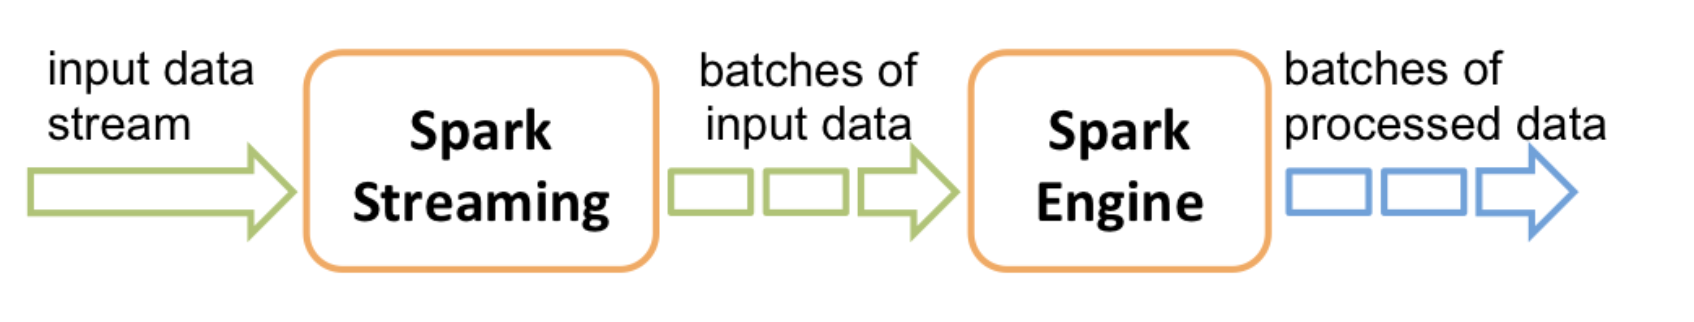

- Susceptible to data loss :Spark streaming put the data in a batch even if the event is generated early and belonged to the earlier batch which may result in less accurate information as it is equal to the data loss

- Use the checkpointing to save the progress of a job to be used in case of failure

- Pyspark streaming is introduced in Spark 1.2


In [1]:
# to count the number of words in text data received from a data server 
#listening on a TCP socket
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

# Create a local StreamingContext with two working thread and batch interval of 1 second
sc = SparkContext("local[2]", "NetworkWordCount")
ssc = StreamingContext(sc, 1)

In [3]:

 

# Create a DStream that will connect to hostname:port, like localhost:9999
lines = ssc.socketTextStream("localhost", 9999)

# Split each line into words
words = lines.flatMap(lambda line: line.split(" "))

# Count each word in each batch
pairs = words.map(lambda word: (word, 1))
wordCounts = pairs.reduceByKey(lambda x, y: x + y)

# Print the first ten elements of each RDD generated in this DStream to the console
wordCounts.pprint()

You will first need to run Netcat (a small utility found in most Unix-like systems) as a data server by runing commnad in commandline:

`nc -lk 9999`

In [2]:
ssc.start()  

ssc.awaitTermination() 

### Basic Concepts
- Spark streaming java library available through Maven Central
-  Ingesting data from sources like Kafka and Kinesis that are not present in the Spark Streaming core API will have to add  spark-streaming-kafka-0-10_2.12, spark-streaming-kinesis-asl_2.12  artifacts 

- While programing do not hard code master in the program but pass it as the argument in spark summit command. However if the job is for local testing and unit tests, you can hardcode “local[*]” to run Spark Streaming in-process

- Sark Streaming Progrming steps 
    - Define  <B> StreamingContext </B> object 
    - Define the <B>input sources </B> by creating input DStreams.
    - Define the <B>streaming computations by applying transformation </B>streaming computations by applying transformation and output operations to DStreams.
    - Start receiving data and processing it using streamingContext.start().
    - Wait for the processing to be stopped (manually or due to any error) using streamingContext.awaitTermination().
    - can be manually stopped using streamingContext.stop().
    
- Notable limitation 
    - Once a context has been started, no new streaming computations can be set up or added to it.
    - Once a context has been stopped, it cannot be restarted.
    - Only one StreamingContext can be active in a JVM at the same time.
    - stop() on StreamingContext also stops the SparkContext..To stop only the StreamingContext, set the optional parameter of stop() called stopSparkContext to false.
    - A SparkContext can be re-used to create multiple StreamingContexts, as long as the previous StreamingContext is stopped 
    



### Discretized Streams (DStreams)

- Discretized Stream or DStream is the basic abstraction provided by Spark Streaming
- represents a continuous stream of data,either the input data stream received from source, or the processed data stream generated by transforming the input stream
- represented by a continuous series of RDDs
- Each RDD in a DStream contains data from a certain interval
- Any operation applied on a DStream translates to operations on the underlying RDD

### Input DStreams and Receivers

- Every input DStream (except file stream ), ( lines in our example) is associated with a Receiver object which receives the data from a source and stores it in Spark’s memory for processing.
- Spark Streaming provides two categories of built-in streaming sources
    1. Basic sources: Sources directly available in the StreamingContext API. Examples: file systems, and socket connections.
    
    2. Advanced sources: Sources like Kafka, Kinesis, etc. are available through extra utility classes. These require linking against extra dependencies as discussed in the linking section.
    
- If you want to receive multiple streams of data in parallel in your streaming application, you can create multiple input DStreams, This will create multiple receivers which will simultaneously receive multiple data streams

- Spark Streaming application needs to be allocated enough cores ,to process the received data, as well as to run the receiver

- on a cluster, the number of cores allocated to the Spark Streaming application must be more than the number of receivers.

### Basic Sources

- Socekt source : example  ssc.socketTextStream(...)
- File Streams :
    - such as HDFS API (that is, HDFS, S3, NFS, etc) use sytax StreamingContext.fileStream[KeyClass, ValueClass, InputFormatClass].
    - File streams do not require running a receiver so there is no need to allocate any cores for receiving file data.
    - streamingContext.textFileStream(dataDirectory)

- How Directories are Monitored ?
    - All files directly, under such a path will be processed  ( "hdfs://namenode:8040/logs/")
    - all files in the directories matching the pattern ("hdfs://namenode:8040/logs/2017/*")
    - All files must be in the same data format
    - considered part of a time period based on its modification time, not its creation time
    - Once processed any updates are ignored.
    - Only the files in the directory whose modification time is within the current window will be included in the stream
    - Calling FileSystem.setTimes() to fix the timestamp is a way to have the file picked up in a later window
    
- Using Object Stores as a source of data
    - Careful testing is needed against the target object store to verify that the timestamp behavior of the store is consistent with that expected by Spark Streaming
    - Filesystems such as HDFS tend to set the modification time on their files as soon as the output stream is created,even before data has been completely written so updates to the file within the same window will be ignored so here To guarantee that changes are picked up in a window, write the file to an unmonitored directory, then, immediately after the output stream is closed, rename it into the destination directory
    - Object Stores such as Amazon S3 and Azure Storage usually have slow rename operations,as the data is actually copied renamed object may have the time of the rename() operation as its modification time, so may not be considered part of the window which the original create time implied they were.

- Streams based on Custom Receivers
    - DStreams can be created with data streams received through custom receivers
- Queue of RDDs as a Stream
    - Each RDD pushed into the queue will be treated as a batch of data in the DStream, and processed like a stream.

- Advanced Sources
     - To minimize issues related to version conflicts of dependencies( say for Kafka and Kinesis), the functionality to create DStreams from these sources has been moved to separate libraries that can be linked to explicitly when necessary.

- Custom Sources
     - not yet supported in Python.
     - its the provision to implement a user-defined receiver

- Receiver Reliability :  two kinds of data sources based on their reliability
    - Reliable Receiver - correctly sends acknowledgment to a reliable source when the data has been received and stored in Spark with replication
    - Unreliable Receiver - does not send acknowledgment to a source

### Transformations on DStreams

- DStreams support many of the transformations available on normal Spark RDD’s.Some of the common ones are :
    - map(func) 
    - flatMap(func) 
    - filter(func) 
    - repartition(numPartitions) 
    - union(otherStream) 
    - count() 
    - reduce(func) 
    - countByValue() 
    - reduceByKey(func, [numTasks]) 
    - join(otherStream, [numTasks]) 
    - cogroup(otherStream, [numTasks]) 
    - transform(func)  :
    
    - updateStateByKey(func)  : updateStateByKey operation allows you to maintain arbitrary state while continuously updating it with new information. To use this, you will have to do two steps.
        - 1. Define the state
        - 2. Define the state update function 
        - using updateStateByKey requires the checkpoint directory to be configured,
    


In [ ]:
def updateFunction(newValues, runningCount):
    if runningCount is None:
        runningCount = 0
    return sum(newValues, runningCount)  # add the new values with the previous running count to get the new count

runningCounts = pairs.updateStateByKey(updateFunction)

In [ ]:
# transform
spamInfoRDD = sc.pickleFile(...)  # RDD containing spam information

# join data stream with spam information to do data cleaning
cleanedDStream = wordCounts.transform(lambda rdd: rdd.join(spamInfoRDD).filter(...))



#### Window Operations

- windowed computations, which allow you to apply transformations over a sliding window of data
- Every time the window slides over a source DStream, the source RDDs that fall within the window are combined and operated upon to produce the RDDs of the windowed DStream.
-  any window operation needs to specify two parameters,two parameters must be multiples of the batch interval of the source DStream
     - window length - The duration of the window (3 in the figure).
     - sliding interval - The interval at which the window operation is performed
     
-  common window operations are as follows
      - window(windowLength, slideInterval) 
      - countByWindow(windowLength, slideInterval) 
      - reduceByWindow(func, windowLength, slideInterval) 
      - reduceByKeyAndWindow(func, windowLength, slideInterval, [numTasks]) 
      - reduceByKeyAndWindow(func, invFunc, windowLength, slideInterval, [numTasks]) 
      - countByValueAndWindow(windowLength, slideInterval, [numTasks]) 
      

In [ ]:
# Reduce last 30 seconds of data, every 10 seconds
windowedWordCounts = pairs.reduceByKeyAndWindow(lambda x, y: x + y, lambda x, y: x - y, 30, 10)



#### Join Operations
- Easily you can perform different kinds of joins in Spark Streaming
- Types of joins
    - Stream-stream joins:  in each batch interval, the RDD generated by stream1 will be joined with the RDD generated by stream2. You can also do leftOuterJoin, rightOuterJoin, fullOuterJoin
    - Stream-dataset joins :

In [ ]:
# Stream-stream joins
stream1 = ...
stream2 = ...
joinedStream = stream1.join(stream2)

In [ ]:
#Stream-dataset joins
#  joining a windowed stream with a dataset.

val dataset: RDD[String, String] = ...
val windowedStream = stream.window(Seconds(20))...
val joinedStream = windowedStream.transform { rdd => rdd.join(dataset) }

#  function provided to transform is evaluated every batch interval and 
#therefore will use the current dataset that dataset reference points to.

### Output Operations on DStreams
- allow DStream’s data to be pushed out to external systems like a database or a file systems by   triggering the actual execution of all the DStream transformations.Examples are 
    - print()
    - saveAsTextFiles(prefix, [suffix]) 
    - saveAsObjectFiles(prefix, [suffix]) 
    - saveAsHadoopFiles(prefix, [suffix]) 
    - foreachRDD(func) 

- Design Patterns for using foreachRDD : Some of the common mistakes to avoid are
     - Its incorect, to creating a connection object at the Spark driver, and then try to use it in a Spark worker to save records in the RDD,as this requires the connection object to be serialized and sent from the driver to the worker. Such connection objects are rarely transferable across machines
     - correct solution is to create the connection object at the worker.

In [ ]:
# incorrect 

def sendRecord(rdd):
    connection = createNewConnection()  # executed at the driver
    rdd.foreach(lambda record: connection.send(record))
    connection.close()

dstream.foreachRDD(sendRecord)



In [ ]:
# correct : create the connection object at the worker
# but its creating a new connection for every record
def sendRecord(record):
    connection = createNewConnection()
    connection.send(record)
    connection.close()

dstream.foreachRDD(lambda rdd: rdd.foreach(sendRecord))



In [ ]:
# better solution is to use rdd.foreachPartition - create a single connection object and 
#send all the records in a RDD partition using that connection.
def sendPartition(iter):
    connection = createNewConnection()
    for record in iter:
        connection.send(record)
    connection.close()

dstream.foreachRDD(lambda rdd: rdd.foreachPartition(sendPartition))

In [ ]:
# more optimized solution 
# reusing connection objects across multiple RDDs/batches
# and further reducing the overheads.


def sendPartition(iter):
    # ConnectionPool is a static, lazily initialized pool of connections
    connection = ConnectionPool.getConnection()
    for record in iter:
        connection.send(record)
    # return to the pool for future reuse
    ConnectionPool.returnConnection(connection)

dstream.foreachRDD(lambda rdd: rdd.foreachPartition(sendPartition))



Note : 
- if your application does not have any output operation, or has output operations like dstream.foreachRDD() without any RDD action inside them, then nothing will get executed. The system will simply receive the data and discard it.
- By default, output operations are executed one-at-a-time. And they are executed in the order they are defined in the application.

### DataFrame and SQL Operations

- is it useful now we have structure streaming ?
- to  use DataFrames and SQL ,create a SparkSession using the SparkContext that the StreamingContext is using. This has to done such that it can be restarted on driver failures. This is done by creating a lazily instantiated singleton instance of SparkSession.
- Each RDD is converted to a DataFrame, registered as a temporary table and then queried using SQL.
- Also,make sure that you set the StreamingContext to remember a sufficient amount of streaming data such that the query can run. Otherwise the StreamingContext, which is unaware of the any asynchronous SQL queries, will delete off old streaming data before the query can complete.For example, if you want to query the last batch, but your query can take 5 minutes to run, then call streamingContext.remember(Minutes(5)

In [ ]:
# Lazily instantiated global instance of SparkSession
def getSparkSessionInstance(sparkConf):
    if ("sparkSessionSingletonInstance" not in globals()):
        globals()["sparkSessionSingletonInstance"] = SparkSession \
            .builder \
            .config(conf=sparkConf) \
            .getOrCreate()
    return globals()["sparkSessionSingletonInstance"]

...

# DataFrame operations inside your streaming program

words = ... # DStream of strings

def process(time, rdd):
    print("========= %s =========" % str(time))
    try:
        # Get the singleton instance of SparkSession
        spark = getSparkSessionInstance(rdd.context.getConf())

        # Convert RDD[String] to RDD[Row] to DataFrame
        rowRdd = rdd.map(lambda w: Row(word=w))
        wordsDataFrame = spark.createDataFrame(rowRdd)

        # Creates a temporary view using the DataFrame
        wordsDataFrame.createOrReplaceTempView("words")

        # Do word count on table using SQL and print it
        wordCountsDataFrame = spark.sql("select word, count(*) as total from words group by word")
        wordCountsDataFrame.show()
    except:
        pass

words.foreachRDD(process)

### MLlib Operations
- First of all, there are streaming machine learning algorithms (e.g. Streaming Linear Regression, Streaming KMeans, etc.) which can simultaneously learn from the streaming data as well as apply the model on the streaming data

- or a much larger class of machine learning algorithms, you can learn a learning model offline (i.e. using historical data) and then apply the model online on streaming data

### Caching / Persistence
-  using the persist() method on a DStream will automatically persist every RDD of that DStream in memory
- DStreams generated by window-based operations are automatically persisted in memory, without the developer calling persist().
- For input streams that receive data over the network (such as, Kafka, sockets, etc.), the default persistence level is set to replicate the data to two nodes for fault-tolerance.

-  Unlike RDDs, the default persistence level of DStreams keeps the data serialized in memory. This is further discussed in the Performance Tuning section.

### Checkpointing
- Spark Streaming needs to checkpoint enough information to a fault- tolerant storage system such that it can recover from failures.
- There are two types of data that are checkpointed 
     - Metadata checkpointing :Saving of the information defining the streaming computation to fault-tolerant storage like HDFS. This is used to recover from failure of the node running the driver of the streaming application (discussed in detail later).primarily needed for recovery from driver failures Metadata includes:

        - Configuration - The configuration that was used to create the streaming application.
        - DStream operations - The set of DStream operations that define the streaming application.
        - Incomplete batches - Batches whose jobs are queued but have not completed yet.
 
     - Data checkpointing : Saving of the generated RDDs to reliable storage. This is necessary in some stateful transformations that combine data across multiple batches. intermediate RDDs of stateful transformations are periodically checkpointed to reliable storage (e.g. HDFS) to cut off the dependency chains. necessary even for basic functioning if stateful transformations are used
    
- When to enable Checkpointing : enabled for applications with any of the following requirements
    - Usage of stateful transformations - If either updateStateByKey or reduceByKeyAndWindow (with inverse function) is used in the application, then the checkpoint directory must be provided to allow for periodic RDD checkpointing.
    - Recovering from failures of the driver running the application - Metadata checkpoints are used to recover with progress information.
    
- Without enabling checkpointing, the recovery from driver failures will be partial (some received but unprocessed data may be lost).

- How to configure Checkpointing ?
    - using streamingContext.checkpoint(checkpointDirectory)
-   streaming application should have the following behavior
    - When the program is being started for the first time, it will create a new StreamingContext, set up all the streams and then call start()
    - When the program is being restarted after failure, it will re-create a StreamingContext from the checkpoint data in the checkpoint directory.
    

- may cause an increase in the processing time of those batches where RDDs get checkpointed
- checkpointing too infrequently causes the lineage and task sizes to grow, which may have detrimental effects.

In [ ]:
# Function to create and setup a new StreamingContext
def functionToCreateContext():
    sc = SparkContext(...)  # new context
    ssc = StreamingContext(...)
    lines = ssc.socketTextStream(...)  # create DStreams
    ...
    ssc.checkpoint(checkpointDirectory)  # set checkpoint directory
    return ssc

# Get StreamingContext from checkpoint data or create a new one
context = StreamingContext.getOrCreate(checkpointDirectory, functionToCreateContext)

# Do additional setup on context that needs to be done,
# irrespective of whether it is being started or restarted
context. ...

# Start the context
context.start()
context.awaitTermination()

# See the Python example recoverable_network_wordcount.py. 
#This example appends the word counts of network data into a file.

### Accumulators, Broadcast Variables, and Checkpoints

-  Accumulators and Broadcast variables cannot be recovered from checkpoint in Spark Streaming.

- In order to  use Accumulators or Broadcast variables  with checkpoint, you’ll have to create lazily instantiated singleton instances for Accumulators and Broadcast variables so that they can be re-instantiated after the driver restarts on failure

In [ ]:
def getWordExcludeList(sparkContext):
    if ("wordExcludeList" not in globals()):
        globals()["wordExcludeList"] = sparkContext.broadcast(["a", "b", "c"])
    return globals()["wordExcludeList"]

def getDroppedWordsCounter(sparkContext):
    if ("droppedWordsCounter" not in globals()):
        globals()["droppedWordsCounter"] = sparkContext.accumulator(0)
    return globals()["droppedWordsCounter"]

def echo(time, rdd):
    # Get or register the excludeList Broadcast
    excludeList = getWordExcludeList(rdd.context)
    # Get or register the droppedWordsCounter Accumulator
    droppedWordsCounter = getDroppedWordsCounter(rdd.context)

    # Use excludeList to drop words and use droppedWordsCounter to count them
    def filterFunc(wordCount):
        if wordCount[0] in excludeList.value:
            droppedWordsCounter.add(wordCount[1])
            False
        else:
            True

    counts = "Counts at time %s %s" % (time, rdd.filter(filterFunc).collect())

wordCounts.foreachRDD(echo)

### Deploying Applications 

To run a Spark Streaming applications, you need to have the following.
- Cluster with a cluster manager 
- Package the application JAR -
- Configuring sufficient memory for the executors -
- Configuring checkpointing -
- Configuring automatic restart of the application driver -
- Configuring write-ahead logs - 
- Setting the max receiving rate -


To Upgrading Application Code,there are two possible mechanisms
-  Upgraded Spark Streaming application is started and run in parallel to the existing application. Once the new one,eceiving the same data as the old one and  s ready for prime time, the old one be can be brought down.that this can be done for data sources that support sending the data to two destinations 

- existing application is shutdown gracefully.Then the upgraded application can be started, which will start processing from the same point where the earlier application left off.can be done only with input sources that support source-side buffering (like Kafka) as data needs to be buffered while the previous application was down and the upgraded application is not yet up.

- Checkpoint is not very benifitial for this as The checkpoint information essentially contains serialized Scala/Java/Python objects and trying to deserialize objects with new, modified classes may lead to errors.


### Monitoring Applications

- Beyond Spark’s monitoring capabilities, there are additional capabilities specific to Spark Streaming

- Spark web UI shows an additional Streaming tab which shows statistics about running receivers (whether receivers are active, number of records received, receiver error, etc.) and completed batches (batch processing times, queueing delays, etc.).(When a StreamingContext is used)

- Following two metrics in web UI are particularly important:
     - Processing Time - The time to process each batch of data.
     - Scheduling Delay - the time a batch waits in a queue for the processing of previous batches to finish.
     
- If the batch processing time is consistently more than the batch interval and/or the queueing delay keeps increasing, then it indicates that the system is not able to process the batches as fast they are being generated and is falling behind. In that case, consider reducing the batch processing time.

- The progress of a Spark Streaming program can also be monitored using the StreamingListener interface, which allows you to get receiver status and processing times. (development under progress)

## Performance Tuning

At a high level, you need to consider two things:
- Reducing the processing time of each batch of data by efficiently using cluster resources.By,
    - consider parallelizing the data receiving
    - by creating multiple input DStreams and configuring them to receive different partitions of the data stream from the source
    - multiple DStreams can be unioned together to create a single DStream
    - Then the transformations that were being applied on a single input DStream
    - spark.streaming.blockInterval.
    - To increase the number of tasks for a given batch interval, reduce the block interval. However, the recommended minimum value of block interval is about 50 ms, below which the task launching overheads may be a problem.
    - The number of tasks per receiver per batch will be approximately (batch interval / block interval). For example, block interval of 200 ms will create 10 tasks per 2 second batches.the recommended minimum value of block interval is about 50 ms
    
    
- Setting the right batch size such that the batches of data can be processed as fast as they are received



In [3]:
# reducing processing time 

numStreams = 5
kafkaStreams = [KafkaUtils.createStream(...) for _ in range (numStreams)]
unifiedStream = streamingContext.union(*kafkaStreams)
unifiedStream.pprint()



Level of Parallelism in Data Processing
- default number of parallel tasks is controlled by the spark.default.parallelism configuration property.
- can pass the level of parallelism as an argument

Data Serialization
   - In the case of streaming, there are two types of data that are being serialized.
      - Input data:
      - Persisted RDDs generated by Streaming Operations
 

### Memory Tuning

- parameters that can help you tune the memory usage and GC overheads:
    - Persistence Level of DStreams:  Enabling Kryo serialization further reduces serialized sizes and memory usage. Further reduction in memory usage can be achieved with compression
    - Clearing old data: all input data and persisted RDDs generated by DStream transformations are automatically cleared. Data can be retained for a longer duration by setting streamingContext.remember.
    - CMS Garbage Collector: Use of the concurrent mark-and-sweep GC is strongly recommended for keeping GC-related pauses consistently low.Even though concurrent GC is known to reduce the overall processing throughput of the system, its use is still recommended to achieve more consistent batch processing times. Make sure you set the CMS GC on both the driver (using --driver-java-options in spark-submit) and the executors (using Spark configuration spark.executor.extraJavaOptions).
    - Other tips:
        - Persist RDDs using the OFF_HEAP storage level.
         - Use more executors with smaller heap sizes.



## Fault-tolerance Semantics
we will discuss the behavior of Spark Streaming applications in the event of failures.

-  for Spark Streaming, the data in most cases is received over the network and to achieve the same fault-tolerance properties for all of the generated RDDs, the received data is replicated among multiple Spark executors in worker nodes in the cluster.This leads to two kinds of data in the system that need to recovered in the event of failures:
    - Data received and replicated - This data survives failure of a single worker node as a copy of it exists on one of the other nodes.
    - Data received but buffered for replication - Since this is not replicated, the only way to recover this data is to get it again from the source.

- There are two kinds of failures that we should be concerned about:
    - Failure of a Worker Node - Any of the worker nodes running executors can fail, and all in-memory data on those nodes will be lost. If any receivers were running on failed nodes, then their buffered data will be lost.
    - Failure of the Driver Node - If the driver node running the Spark Streaming application fails, then obviously the SparkContext is lost, and all executors with their in-memory data are lost.
    
- Let us understand the fault-tolerance semantics of Spark Streaming.There are three types of guarantees that a system can provide under all possible operating conditions
    - At most once: Each record will be either processed once or not processed at all.
    - At least once: Each record will be processed one or more times. This is stronger than at-most once as it ensure that no data will be lost. But there may be duplicates.
    - Exactly once: Each record will be processed exactly once - no data will be lost and no data will be processed multiple times. This is obviously the strongest guarantee of the three.

